## Rover Response Optimization

This notebook shows how variables in an fmdtools model can be optimized for resilience.

In [1]:
import sys, os
sys.path.insert(0, os.path.join('..'))
sys.path.insert(0, os.path.join('..','..'))

from fmdtools.modeldef import *
import fmdtools.resultdisp as rd
import fmdtools.faultsim.propagate as prop
import fmdtools.faultsim.search as search
import matplotlib.pyplot as plt
import multiprocessing as mp
import time

Model is in defined rover_model.py

In [2]:
from rover_model import Rover, gen_params, plot_map, plot_trajectories

## Optimization

Here we define the optimization problem for the rover.

We use a parallel pool, staged execution, and minimal tracking options to lower computational cost as much as possible.

In [3]:
mdl = Rover()
mdl.modelparams['use_end_condition']=False
track={'functions':{"Environment":"in_bound"},'flows':{"Ground":"all"}}
rover_prob = search.ProblemInterface("rover_problem", mdl, pool=mp.Pool(5), staged=True, track=track)

In [4]:
mdl.params

{'linetype': 'turn',
 'radius': 20,
 'start': 20,
 'initangle': 0.0,
 'end': [40, 40],
 'ub_f': 10,
 'lb_f': -1,
 'ub_t': 10,
 'lb_t': -1,
 'ub_d': 2,
 'lb_d': -2,
 'cor_f': 1,
 'cor_d': 1,
 'cor_t': 1,
 'degradation': {'friction': 0.0, 'drift': 0.0}}

Here we will be optimizing over faults in the drive system at 3 points during the drive simulation interval:

In [5]:
app_drive = SampleApproach(mdl, faults='Drive', phases={'global':[0,39]}, defaultsamp={'samp':'evenspacing','numpts':3})
rover_prob.add_simulation("drive_faults", "multi", app_drive.scenlist)

The variables are the correction factors int the fault management: 

In [6]:
rover_prob.add_variables("drive_faults", ("cor_f", (-10,100)), ("cor_d", (-100, 100)), ("cor_t", (-10,100)), vartype="param")

We can define multiple objectives, below we will use the end distance from find_classification. 

In [7]:
rover_prob.add_objectives("drive_faults", end_dist="end_dist", tot_deviation="tot_deviation")

Here we do some basic timing:

In [8]:
rover_prob.end_dist([0.5,0.5,0.5])
a=time.time()
rover_prob.end_dist([0.6,0.5,0.5])
t=time.time()-a

In [9]:
t

1.062434196472168

In [10]:
rover_prob

Problem rover_problem                                                   current value
 Variables
 -param cor_f at t=0: (-10, 100)                                               0.6000
 -param cor_d at t=0: (-100, 100)                                              0.5000
 -param cor_t at t=0: (-10, 100)                                               0.5000
 Objectives
 -end_dist: +sum(drive_faults endclass end_dist at t=end)                   4092.9231
 -tot_deviation: +sum(drive_faults endclass tot_deviation at t=end)              0.0000
 Constraints
 -
 Simulations
 -drive_faults: multi scen: 

### Rover Optimization: 

In [12]:
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
import numpy as np

In [13]:
pymoo_prob = rover_prob.to_pymoo_problem(objectives="end_dist")

In [14]:
arg={}
pymoo_prob._evaluate([1,1,2],arg)

In [15]:
arg

{'F': array([[4043.51745229]])}

In [16]:
algorithm=PatternSearch(x0=np.array([0,0,0])) 

In [17]:
res = minimize(pymoo_prob, algorithm, verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        1 |  4.722458E+03 |  4.722458E+03
     2 |        6 |  4.619667E+03 |  4.516875E+03
     3 |       13 |  4.514388E+03 |  4.511902E+03
     4 |       20 |  4.511902E+03 |  4.511902E+03
     5 |       25 |  4.508415E+03 |  4.504927E+03
     6 |       32 |  4.504927E+03 |  4.504927E+03
     7 |       38 |  4.462585E+03 |  4.420243E+03
     8 |       43 |  4.366915E+03 |  4.313588E+03
     9 |       50 |  4.291354E+03 |  4.269120E+03
    10 |       57 |  4.269120E+03 |  4.269120E+03
    11 |       61 |  4.207746E+03 |  4.146372E+03
    12 |       68 |  4.146372E+03 |  4.146372E+03
    13 |       73 |  4.120119E+03 |  4.093866E+03
    14 |       79 |  4.045949E+03 |  3.998033E+03
    15 |       85 |  3.974255E+03 |  3.950477E+03
    16 |       91 |  3.939813E+03 |  3.929149E+03
    17 |       97 |  3.952247E+03 |  3.929149E+03
    18 |      103 |  3.927751E+03 |  3.926354E+03
    19 |      108 |  3.930004E+03 |  3.926354E+03


In [22]:
res.X

array([ 0.88623047, 45.8664544 , -1.06384236])

### Results visualization

Here we look at the optimized results and compare with the starting results:

In [26]:
rover_prob.end_dist([ 0.88623047, 45.8664544 , -1.06384236])

3910.4030316859735

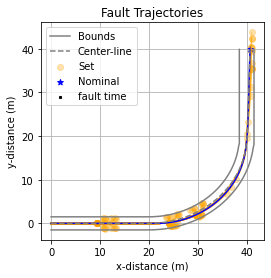

In [27]:
fig = plot_trajectories(rover_prob._sims['drive_faults']['mdlhists'], app= app_drive)

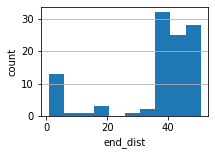

In [28]:
ecs = {k: v['endclass'] for k, v in rover_prob._sims['drive_faults']['results'].items()}
fig = rd.plot.metric_dist(ecs, 'end_dist')

starting solution:

In [29]:
rover_prob.end_dist([0,0,0])

4722.458157103226

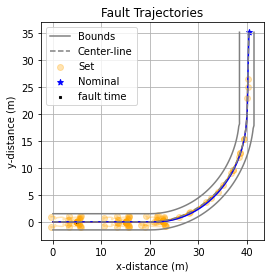

In [30]:
fig = plot_trajectories(rover_prob._sims['drive_faults']['mdlhists'], app= app_drive)

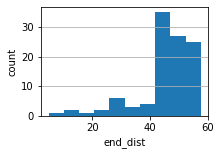

In [31]:
ecs = {k: v['endclass'] for k, v in rover_prob._sims['drive_faults']['results'].items()}
fig = rd.plot.metric_dist(ecs, 'end_dist')

As shown, while the optimized correction factors don't mitigate all scenarios, they do increase the number of scenarios that are mitigated.